# CNN Cancer Detector Mini Project

In this project, We must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset is form by 220025 images tagged with 0 for benign and 1 malignant. The solution is going to use a Covolutional Neuronal Network. We are going to start with a Exploratory Data Analysis, then build a basic model, then tuning the model and conclutions.

In [165]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange
from PIL import Image
from glob import glob
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [166]:
train_csv = 'data/train_labels.csv'
train_path = 'data/train'

df = pd.read_csv(train_csv)

df['image'] = df['id'] + '.tif'

df['label'] = df['label'].astype(str)

df.head()

,id,label,image
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


### Exploratory Data Analysis (EDA) 

In [173]:
df.shape

(220025, 3)

In [6]:
df.isnull().sum()

id       0
label    0
image    0
dtype: int64

The is not missing data in the dataset.

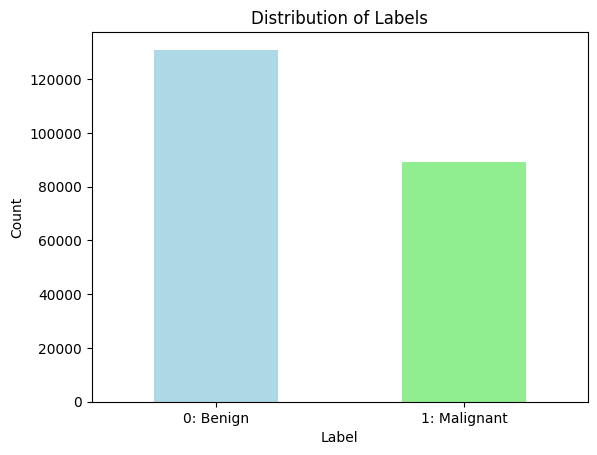

In [21]:
ax = df['label'].value_counts().plot(kind='bar', color=['lightblue', 'lightgreen'])

plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['0: Benign', '1: Malignant'], rotation=0)
plt.show()

In [175]:
df['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

there are 130908 Benign and 89117 Malignant imagenes. The classes are well distributed.

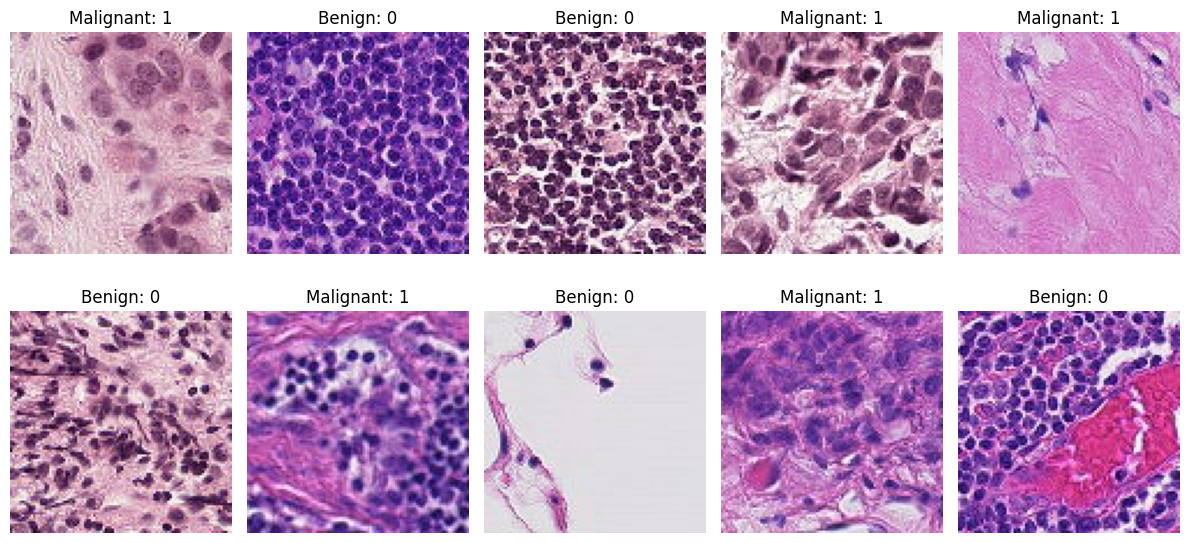

In [59]:
num_samples = 10

fig, axes = plt.subplots(2, num_samples//2, figsize=(12, 6))
sample_images = df.sample(num_samples).reset_index(drop=True)

for i, ax in enumerate(axes.flat):
    img_path = os.path.join(train_path, sample_images.loc[i, 'image'])
    img = Image.open(img_path)
    ax.imshow(img, cmap="gray")
    label = 'Benign: 0' if sample_images.loc[i, 'label'] == 0 else 'Malignant: 1'
    ax.set_title(f"{label}")
    
    ax.axis("off")

plt.tight_layout()
plt.show()


<Figure size 800x400 with 0 Axes>

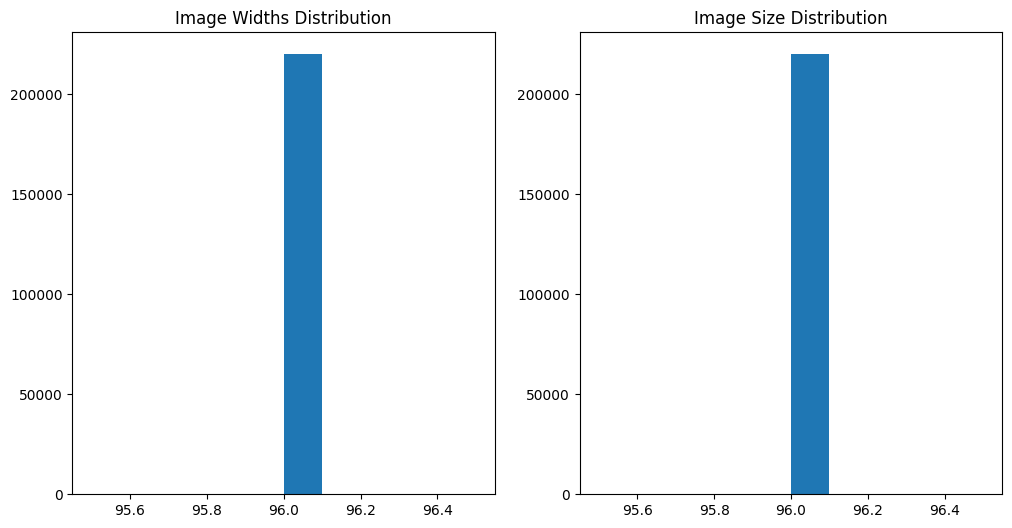

In [54]:
image_files = glob(os.path.join(train_path, "*.tif"))
image_shapes = [Image.open(img).size for img in image_files]
widths, heights = zip(*image_shapes)

plt.figure(figsize=(8, 4))

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(widths)
axes[0].set_title(f"Image Widths Distribution")

axes[1].hist(heights)
axes[1].set_title(f"Image Heights Distribution")

plt.title("Image Size Distribution")
plt.show()

Images dimesion is 96x96

data/train/801b937387d59298132ef24bb2ba06a2af62fc5f.tif


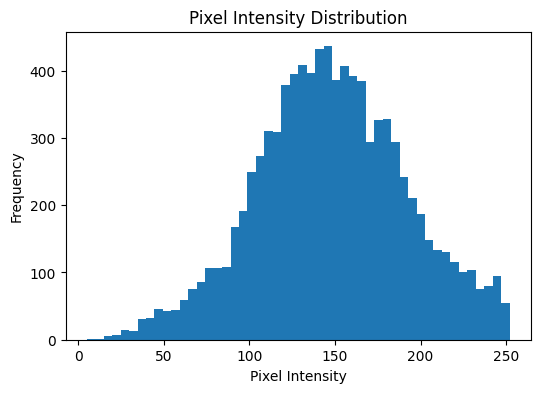

In [70]:
random_img_path = np.random.choice(image_files)

print(random_img_path)

img = cv2.imread(random_img_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(6, 4))
plt.hist(img.ravel(), bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()


Pixels intensity are following a normal distribution.

### DModel Architecture

In this section we are going to build a Convolutional Neural Network. The CNN architecture is conformed by 2 principal components. The feature extractor and the classification layer. In the feature extractor layer, we are going to apply a 2D convolution with 69 filters with a 3x3 dimension and a ReLU activation function. The classification layer is going to have 1 layer with 128 neurons with ReLU activator and the output layer with 1 neuron with sigmoid activation.

In [160]:
BATCH_SIZE = 50
EPOCHS = 5

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=(0.8, 1.2)
)

datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="image",
    y_col="label",
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_path,
    x_col="image",
    y_col="label",
    target_size=(96, 96),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [143]:
def plot_acc_and_loss(metrics):
    acc = metrics.history['acc']
    val_acc = metrics.history['val_acc']
    loss = metrics.history['loss']
    val_loss = metrics.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training ACC')
    plt.plot(epochs_range, val_acc, label='Validation ACC')
    plt.xlabel('Epochs')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation ACC')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.show()
    


In [161]:
model_0 = models.Sequential([

layers.Conv2D(64, (3, 3), activation="relu", input_shape=(96, 96, 3)),
layers.MaxPooling2D((2, 2)),

layers.Flatten(),
layers.Dense(128, activation="relu"),
layers.Dense(1, activation="sigmoid")
])

model_0.compile(optimizer="adam",
          loss="binary_crossentropy",
          metrics=["accuracy"])

model_0.summary()

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 141376)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │    18,096,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,098,177 (69.04 MB)

 Trainable params: 18,098,177 (69.04 MB)

 Non-trainable params: 0 (0.00 B)

In [162]:
model_0.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

In [163]:
history_0 = model_0.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

Epoch 1/5


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:780: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


3521/3521 ━━━━━━━━━━━━━━━━━━━━ 334s 95ms/step - acc: 0.7657 - loss: 0.5135 - val_acc: 0.8150 - val_loss: 0.4175
Epoch 2/5
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 318s 90ms/step - acc: 0.8188 - loss: 0.4061 - val_acc: 0.8282 - val_loss: 0.3949
Epoch 3/5
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 310s 88ms/step - acc: 0.8334 - loss: 0.3791 - val_acc: 0.8316 - val_loss: 0.3896
Epoch 4/5
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 309s 88ms/step - acc: 0.8500 - loss: 0.3450 - val_acc: 0.8217 - val_loss: 0.4015
Epoch 5/5
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 312s 89ms/step - acc: 0.8674 - loss: 0.3109 - val_acc: 0.8257 - val_loss: 0.3992


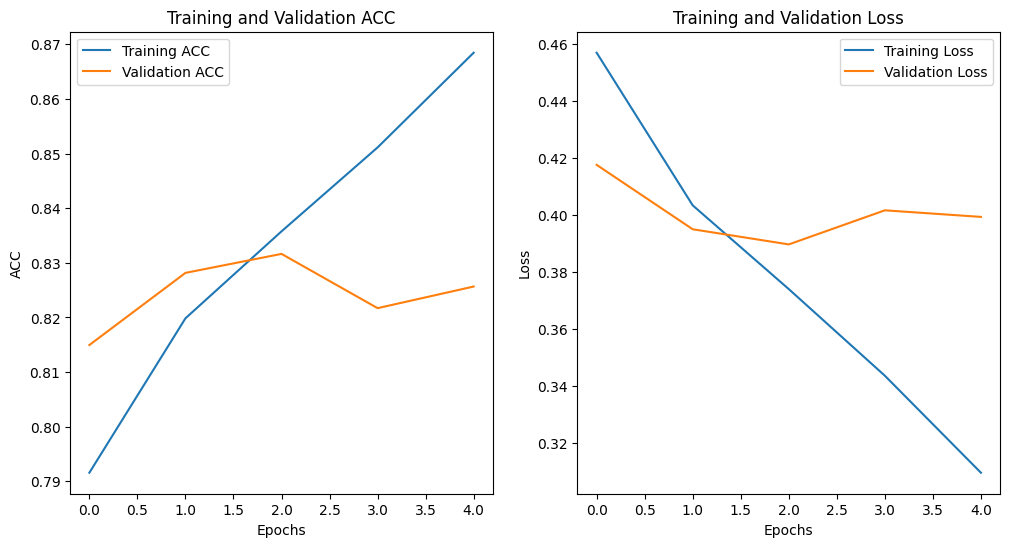

In [164]:
plot_acc_and_loss(history_0)

### Results and Analysis

In this section, we are tuning the CNN using three approaches. Improving the feature layer complexity using transfer learning and re-training the weights.

The first approach, We are going to change the feature extraction architecture applying multiple convolutions and batch normalization. In the clasification layer we are going to include a Dropout of 50% to avoid the overfiting. 

In [154]:
EPOCHS = 20
model = models.Sequential([

layers.Conv2D(64, (3, 3), activation="relu", input_shape=(96, 96, 3)),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),

layers.Conv2D(128, (3, 3), activation="relu"),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),

layers.Conv2D(256, (3, 3), activation="relu"),
layers.BatchNormalization(),
layers.MaxPooling2D((2, 2)),

layers.Flatten(),
layers.Dense(128, activation="relu"),
layers.Dropout(0.5),
layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
          loss="binary_crossentropy",
          metrics=["accuracy"])

model.summary()

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 94, 94, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,649,665 (13.92 MB)

 Trainable params: 3,648,769 (13.92 MB)

 Non-trainable params: 896 (3.50 KB)

In [153]:
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)


In [118]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1590s 451ms/step - acc: 0.8710 - loss: 0.3189 - val_acc: 0.8715 - val_loss: 0.3541
Epoch 2/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1595s 453ms/step - acc: 0.9154 - loss: 0.2240 - val_acc: 0.8660 - val_loss: 0.3349
Epoch 3/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1583s 450ms/step - acc: 0.9313 - loss: 0.1846 - val_acc: 0.8623 - val_loss: 0.3378
Epoch 4/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1722s 489ms/step - acc: 0.9437 - loss: 0.1533 - val_acc: 0.9016 - val_loss: 0.2995
Epoch 5/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1617s 459ms/step - acc: 0.9522 - loss: 0.1291 - val_acc: 0.8968 - val_loss: 0.3801
Epoch 6/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1603s 455ms/step - acc: 0.9609 - loss: 0.1078 - val_acc: 0.6575 - val_loss: 2.2818
Epoch 7/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1591s 452ms/step - acc: 0.9653 - loss: 0.0965 - val_acc: 0.8085 - val_loss: 0.9018
Epoch 8/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1588s 451ms/step - acc: 0.9719 - loss: 0.0795 - val_acc: 0.8745 - val_loss: 0.4605


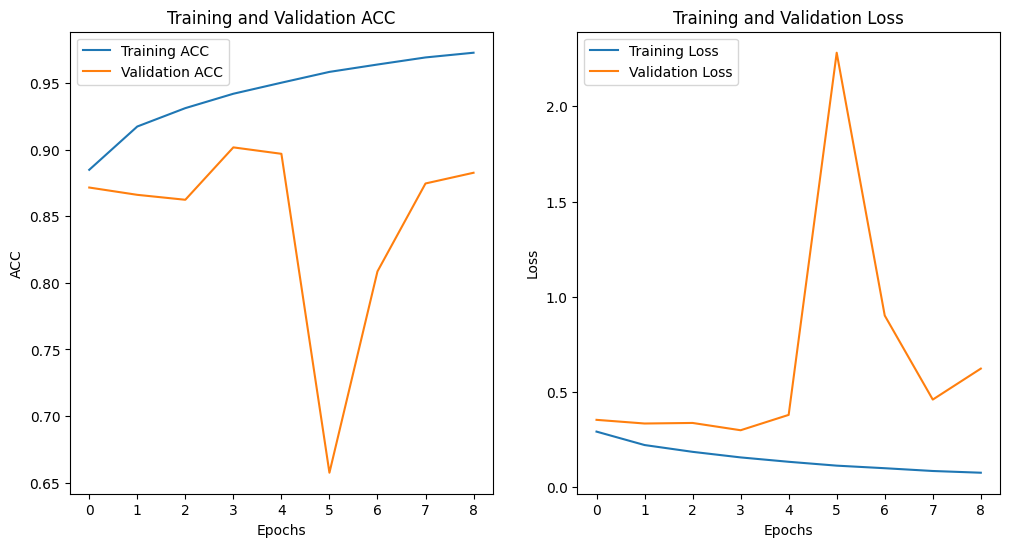

In [144]:
plot_acc_and_loss(history)

The second approach we are going to use is transfer learning with ResNet50 as a feature extractor using the pre-training weights of the model. Using a pre-trained model reduces the computational time and may increase the quality of the features extracted.

In [124]:
base_model = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(96, 96, 3))

base_model.trainable = False  

model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


model_2.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model_2.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [126]:
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1111s 315ms/step - acc: 0.6260 - loss: 0.6414 - val_acc: 0.7099 - val_loss: 0.5679
Epoch 2/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1077s 306ms/step - acc: 0.7064 - loss: 0.5676 - val_acc: 0.7215 - val_loss: 0.5456
Epoch 3/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1090s 310ms/step - acc: 0.7197 - loss: 0.5522 - val_acc: 0.7341 - val_loss: 0.5301
Epoch 4/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1104s 314ms/step - acc: 0.7270 - loss: 0.5431 - val_acc: 0.7365 - val_loss: 0.5250
Epoch 5/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1101s 313ms/step - acc: 0.7316 - loss: 0.5362 - val_acc: 0.7425 - val_loss: 0.5203
Epoch 6/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1097s 312ms/step - acc: 0.7328 - loss: 0.5337 - val_acc: 0.7430 - val_loss: 0.5152
Epoch 7/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1105s 314ms/step - acc: 0.7369 - loss: 0.5299 - val_acc: 0.7434 - val_loss: 0.5132
Epoch 8/20
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 1082s 307ms/step - acc: 0.7390 - loss: 0.5264 - val_acc: 0.7475 - val_loss: 0.5104


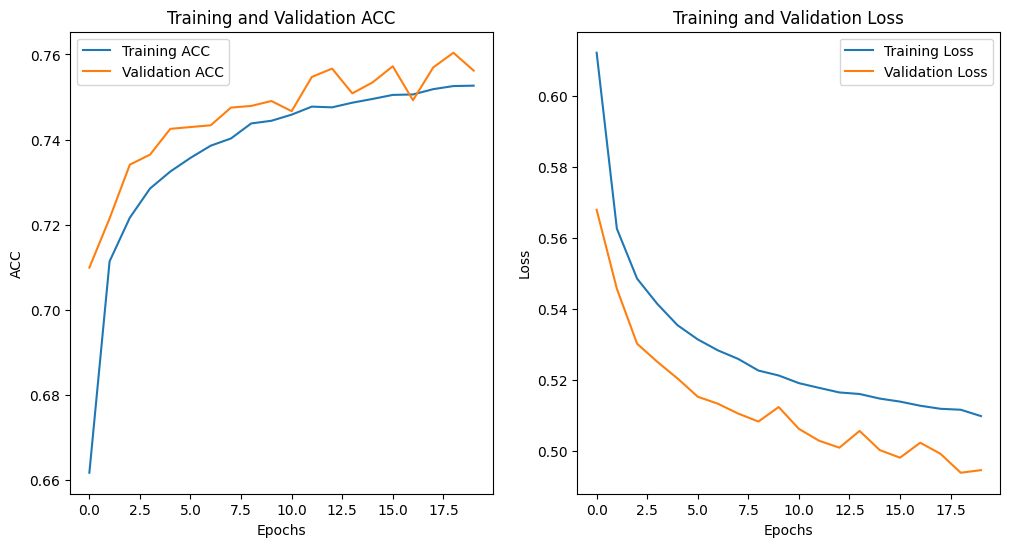

In [145]:
plot_acc_and_loss(history_2)

We are going to use transfer learning with ResNet50 as a feature extractor and train the base model starting from the 100th layer. Making a partial training of the feature extractor layer may fit the layer for our use case, increasing the quality of the model.

In [150]:
EPOCHS = 10

base_model_3 = ResNet50(
    weights='imagenet', 
    include_top=False, 
    input_shape=(96, 96, 3))

base_model_3.trainable = True

for layer in base_model_3.layers[:100]:
    layer.trainable = False
    
model_3 = models.Sequential([
    base_model_3,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


model_3.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

model_3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 19,715,329 (75.21 MB)

 Non-trainable params: 4,134,784 (15.77 MB)

In [151]:
history_3 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)


Epoch 1/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2593s 735ms/step - acc: 0.7468 - loss: 0.5264 - val_acc: 0.7680 - val_loss: 0.5244
Epoch 2/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2514s 714ms/step - acc: 0.7973 - loss: 0.4531 - val_acc: 0.6615 - val_loss: 0.6282
Epoch 3/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2715s 771ms/step - acc: 0.8104 - loss: 0.4268 - val_acc: 0.5962 - val_loss: 1.6236
Epoch 4/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2787s 791ms/step - acc: 0.8174 - loss: 0.4128 - val_acc: 0.7250 - val_loss: 0.5546
Epoch 5/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2777s 789ms/step - acc: 0.8256 - loss: 0.3951 - val_acc: 0.7638 - val_loss: 0.4942
Epoch 6/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2651s 753ms/step - acc: 0.8332 - loss: 0.3817 - val_acc: 0.8166 - val_loss: 0.4084
Epoch 7/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2670s 758ms/step - acc: 0.8374 - loss: 0.3733 - val_acc: 0.5458 - val_loss: 1.2517
Epoch 8/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 2476s 703ms/step - acc: 0.8407 - loss: 0.3664 - val_acc: 0.7165 - val_loss: 0.5965


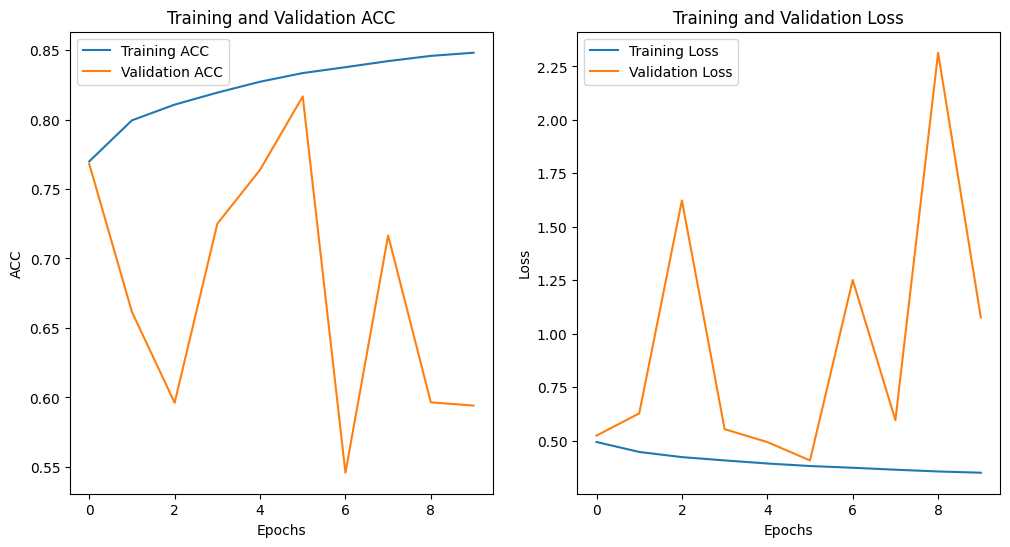

In [152]:
plot_acc_and_loss(history_3)

### Conclusion

- The first model shows an accuracy of 86%. However, observing the validation accuracy, we can conclude that there is overfitting because the validation accuracy is decreasing from the 2nd epoch.

- The second model implemented a more complex feature extractor using several times the convolution, batch normalization, and max pooling. A dropout of 50% is used in the classification layer. This model has gotten an accuracy of 97%, and the validation accuracy is 84%, proving less overfitting than the previous one.

- In model 3, we are using transfer learning techniques with the ResNet50 model as a feature extractor and only training the classification layer. This model was more time-consuming because of the complexity. After 20 epochs, the gotten accuracy was 75%. This result looks worse against the first two models; however, the model doesn't have the overfitting issue because we can see that the validation accuracy is better than the training.

- The last model uses a similar approach to model 3, adding training in the feature extractor in the last 75 layers. This model is more time-consuming than the previous 3. However, the model gets 84% accuracy, but the overfitting is higher than the other models.

- We can conclude that model 2 has the better result with 97% of training accuracy and 84% of test accuracy. The model 3 also has the potential to be a good fit, increasing the learning rate to allow the model to converge to a better solution.

- For future works, we can tune the architecture of the neural network using different learning rates, try transfer learning with different models, and use different optimization functions.